## Regression with BIWI head pose dataset

This is a more advanced example to show how to create custom datasets and do regression with images. Our task is to find the center of the head in each image. The data comes from the [BIWI head pose dataset](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db), thanks to Gabriele Fanelli et al. We have converted the images to jpeg format, so you should download the converted dataset from [this link](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

**이건 이해하기 어렵다.. 일단 calibration이 뭔지 잘 모르겠다. https://3months.tistory.com/490 를 읽어봤는데, 모형의 출력값이 실제 확률을 반영하도록 만드는 것이라고 하지만(이것도 밑에서 쓰인 calibration의 의미와 동일한지 모르겠다), 그게 밑에서 어떻게 적용되는 것인지 감이 오지 않는다. 그리고 밑에서 만들어준 get_ctr과 get_ip는 이름으로 보아 어떤 일을 하는지 대충 짐작할 수 있는데, convert_biwi는 도무지 뭘 하는지를 모르겠어서 어떤 과정으로 저렇게 점을 찍어주는지 알 수 없다.**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

## Getting and converting the data

In [0]:
path = untar_data(URLs.BIWI_HEAD_POSE)

조금 특이한 데이터셋이다. 이건 어디가 얼굴의 중앙인지를 알려주는 점을 가지고 있다. 즉, 우리는 얼굴 중앙점을 찾는 model을 만들 것이다. 

In [4]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

calibration number를 받아온다.

In [0]:
fname = '09/frame_00667_rgb.jpg'

일단 데이터중에 사진 하나를 가져와서 보여준다.

In [0]:
def img2txt_name(f): return path/f'{str(f)[:-7]}pose.txt'

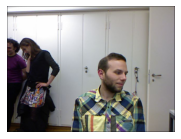

In [7]:
img = open_image(path/fname)
img.show()

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

**convert_biwi가 뭘 하는걸까?**

In [10]:
get_ctr(fname)

tensor([263.9104, 428.5814])

해당 이미지의 얼굴 center 위치는 위와 같다.

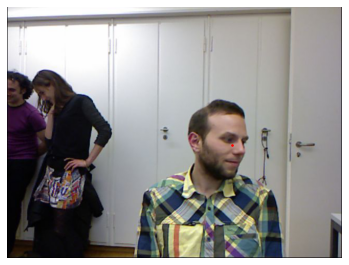

In [11]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6, 6))

알아낸 center를 점으로 찍어줬다.

## Creating a dataset

In [0]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

get_ctr로 점찍힌 label들이 붙은 데이터셋을 만들고,

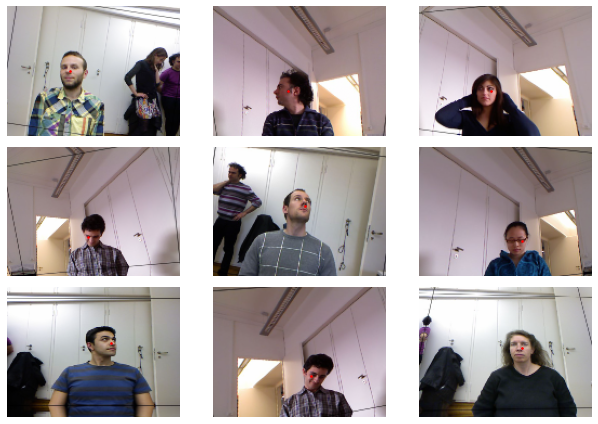

In [13]:
data.show_batch(3, figsize=(9,6))

이런 사진들이 있음을 보여준다.
아래는 익숙한 과정들이므로 comment를 생략한다.

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


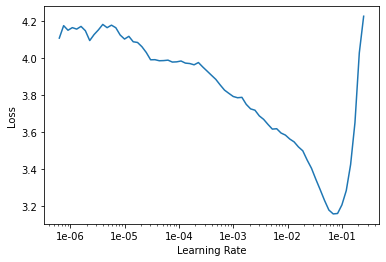

In [15]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 2e-2

In [17]:
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,time
0,0.125878,0.029876,03:34
1,0.034430,0.007155,03:34
2,0.014723,0.002124,03:33
3,0.008719,0.003010,03:34


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

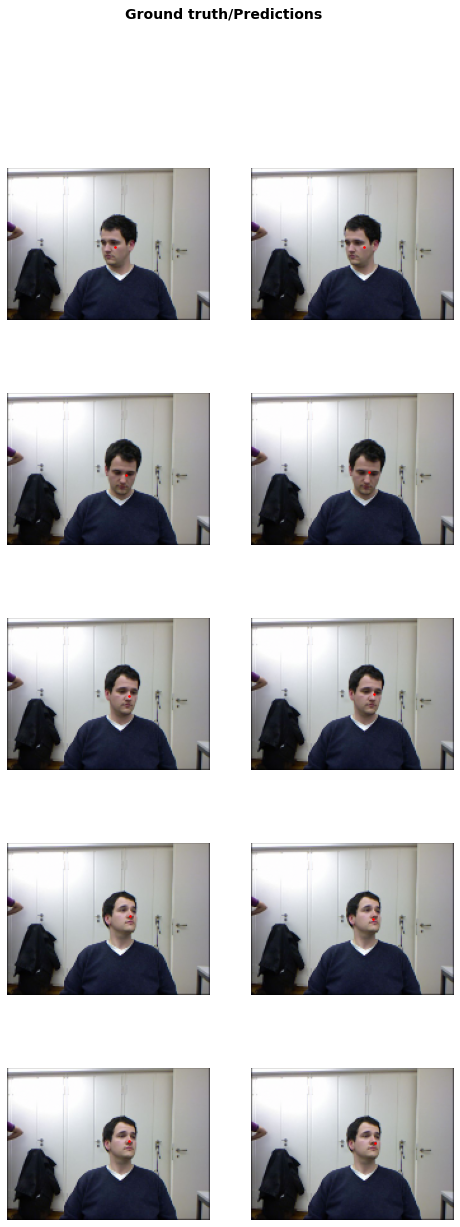

In [20]:
learn.show_results()

왼쪽이 실제고 오른쪽이 예측인데, 두 점의 위치가 거의 비슷하다. 꽤 잘 예측된 것 같다.

## Data augmentation

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

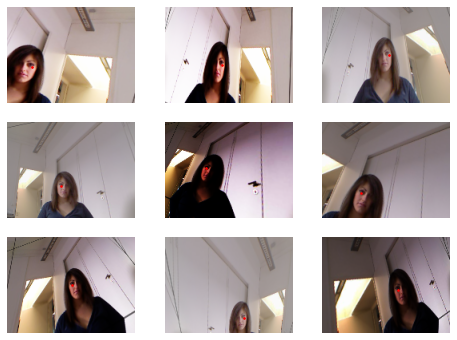

In [22]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))